In [1]:
# 1. KÜTÜPHANELER
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc,
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score
)
import warnings
warnings.filterwarnings('ignore')
import shap

In [2]:
# 2. VERİ YÜKLEME VE HAZIRLIK
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name='target')

print("Veri seti boyutu:", X.shape)
print("Özellik sayısı:", X.shape[1])
print("Örnek sayısı:", X.shape[0])
print("Sınıf dağılımı:\n", y.value_counts().sort_index())
print("Sınıf isimleri:",  wine.target_names)

Veri seti boyutu: (178, 13)
Özellik sayısı: 13
Örnek sayısı: 178
Sınıf dağılımı:
 target
0    59
1    71
2    48
Name: count, dtype: int64
Sınıf isimleri: ['class_0' 'class_1' 'class_2']


In [3]:
# 3. VERİ BÖLME
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
)

print("Train set:", X_train.shape)
print("Validation set:",  X_val.shape)
print("Test set:", X_test.shape)


Train set: (124, 13)
Validation set: (18, 13)
Test set: (36, 13)


In [4]:
# 4. METRİKLER FONKSİYONU
# =============================================================================

def evaluate_model(y_true, y_pred, y_proba, model_name="Model"):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (macro)': precision_score(y_true, y_pred, average='macro'),
        'Recall (macro)': recall_score(y_true, y_pred, average='macro'),
        'F1-Score (macro)': f1_score(y_true, y_pred, average='macro'),
        'ROC-AUC (OvR)': roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
    }

Baseline (k=5) F1-Score: 1.0
En iyi parametreler: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}
En iyi CV F1-Score: 0.9846164430684554
Validation F1-Score: {knn_metrics['F1-Score (macro)']:.4f}


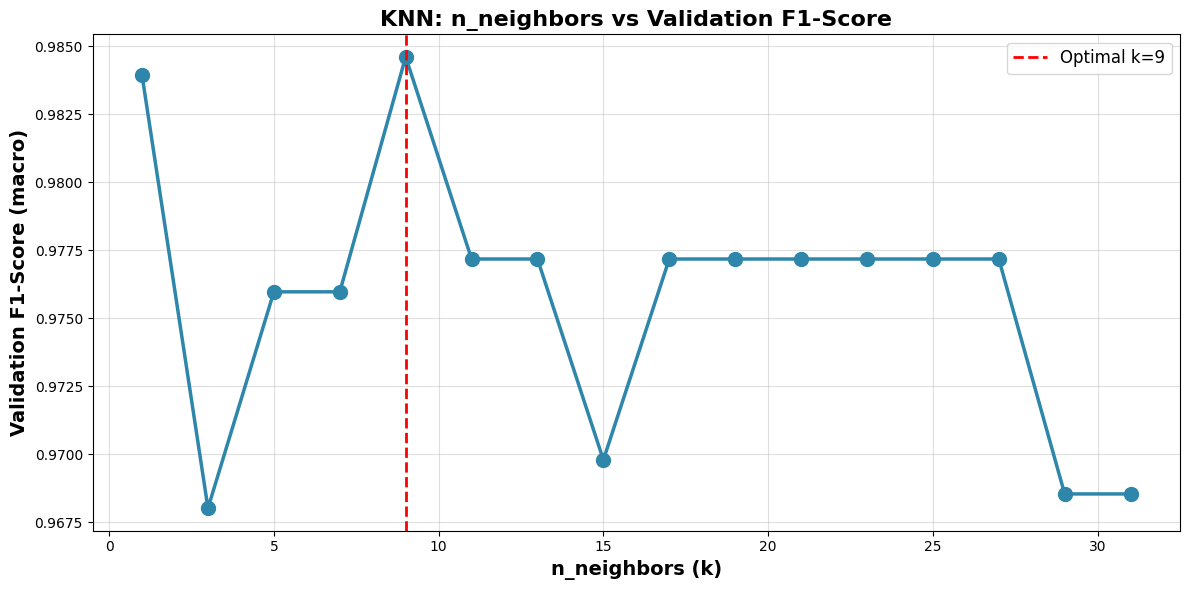

In [5]:
# 5. KNN SINIFLANDIRMA

# Model
knn_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])
knn_baseline.fit(X_train, y_train)
y_val_pred_baseline = knn_baseline.predict(X_val)
y_val_proba_baseline = knn_baseline.predict_proba(X_val)
baseline_f1 = f1_score(y_val, y_val_pred_baseline, average='macro')
print("Baseline (k=5) F1-Score:", baseline_f1)

# Hiperparametre optimizasyonu
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'knn__n_neighbors': list(range(1, 32, 2)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

grid_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='f1_macro', n_jobs=-1)
grid_knn.fit(X_train, y_train)

print("En iyi parametreler:", grid_knn.best_params_)
print("En iyi CV F1-Score:", grid_knn.best_score_)

y_val_pred_knn = grid_knn.predict(X_val)
y_val_proba_knn = grid_knn.predict_proba(X_val)
knn_metrics = evaluate_model(y_val, y_val_pred_knn, y_val_proba_knn, "KNN")

print("Validation F1-Score: {knn_metrics['F1-Score (macro)']:.4f}")

# GRAFİK 1: n_neighbors vs F1
results_df = pd.DataFrame(grid_knn.cv_results_)
n_neighbors_scores = []
for n in range(1, 32, 2):
    mask = results_df['param_knn__n_neighbors'] == n
    if mask.any():
        best_score = results_df[mask]['mean_test_score'].max()
        n_neighbors_scores.append((n, best_score))

n_vals, f1_vals = zip(*n_neighbors_scores)

plt.figure(figsize=(12, 6))
plt.plot(n_vals, f1_vals, marker='o', linewidth=2.5, markersize=10, color='#2E86AB')
plt.axvline(x=grid_knn.best_params_['knn__n_neighbors'],
            color='red', linestyle='--', linewidth=2,
            label=f'Optimal k={grid_knn.best_params_["knn__n_neighbors"]}')
plt.xlabel('n_neighbors (k)', fontsize=14, fontweight='bold')
plt.ylabel('Validation F1-Score (macro)', fontsize=14, fontweight='bold')
plt.title('KNN: n_neighbors vs Validation F1-Score', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# ***KNN Teknik Yorum:***
1. KNN mesafe tabanlı bir model ve mesafe hesaplamalarında değerlerin kareleri kullanıyor olması sebebiyle, modelin daha sağlıklı çalışması için StandardScaler büyük bir önem taşımaktadır.
2. k=9 değerinde optimum seviyeye ulaşılarak overfitting ve underfitting dengesi sağlanmıştır.
3. Yakın komşuların daha fazla ağırlık alması sebebiyle en iyi parametrelerde 'knn__weights': 'uniform' olarak karşımıza çıkmaktadır.

In [6]:
# 6. SVM SINIFLANDIRMA
# Linear SVM
svm_linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))
])
param_grid_svm_linear = {'svm__C': [0.01, 0.1, 1, 10, 100]}
grid_svm_linear = GridSearchCV(svm_linear_pipeline, param_grid_svm_linear, cv=5, scoring='f1_macro', n_jobs=-1)
grid_svm_linear.fit(X_train, y_train)
print("Linear SVM en iyi C:", grid_svm_linear.best_params_['svm__C'])

# RBF SVM
svm_rbf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])
param_grid_svm_rbf = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}
grid_svm_rbf = GridSearchCV(svm_rbf_pipeline, param_grid_svm_rbf, cv=5, scoring='f1_macro', n_jobs=-1)
grid_svm_rbf.fit(X_train, y_train)
print("RBF SVM en iyi parametreler:", grid_svm_rbf.best_params_)

# Validation performansları
y_val_pred_linear = grid_svm_linear.predict(X_val)
y_val_proba_linear = grid_svm_linear.predict_proba(X_val)
svm_linear_metrics = evaluate_model(y_val, y_val_pred_linear, y_val_proba_linear, "SVM-Linear")

y_val_pred_rbf = grid_svm_rbf.predict(X_val)
y_val_proba_rbf = grid_svm_rbf.predict_proba(X_val)
svm_rbf_metrics = evaluate_model(y_val, y_val_pred_rbf, y_val_proba_rbf, "SVM-RBF")

print("Linear F1:", svm_linear_metrics['F1-Score (macro)'])
print("RBF F1:", svm_rbf_metrics['F1-Score (macro)'])

best = "RBF" if svm_rbf_metrics['F1-Score (macro)'] > svm_linear_metrics['F1-Score (macro)'] else "Linear"
print("En İyi SVM:", best, "kernel")

Linear SVM en iyi C: 1
RBF SVM en iyi parametreler: {'svm__C': 100, 'svm__gamma': 0.01}
Linear F1: 1.0
RBF F1: 1.0
En İyi SVM: Linear kernel


# ***SVM Teknik Yorum:***

1. SVM algoritması, sınıfları ayıran en geniş marjı hesaplarken veri noktaları arasındaki uzaklığı (Euclidean) temel aldığı için StandardScaler kullanımı model performansının tutarlılığı açısından kritik öneme sahiptir.
2. Hem Linear hem de RBF kernel ile 1.0 F1 skoru elde edilmiştir. Hesaplama maliyetinin düşüklüğü ve açıklanabilirliğin yüksek olması sebebiyle (Occam's Razor ilkesi), karmaşık RBF yerine Linear Kernel tercih edilmesi en doğru yaklaşımdır.
3. RBF modelinin yüksek ceza parametresi ($C=100$) ile veriye zoraki uymaya çalışmasına karşın, Linear modelin standart regülarizasyon ($C=1$) ile aynı başarıyı yakalaması, veri setinin doğrusal olarak ayrılabilir (linearly separable) yapıda olduğunu kanıtlar.

En iyi parametreler: {'mlp__activation': 'relu', 'mlp__alpha': 1e-05, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.01}
En iyi CV F1-Score: 0.9458848667672196
Validation F1-Score: 0.9407407407407407


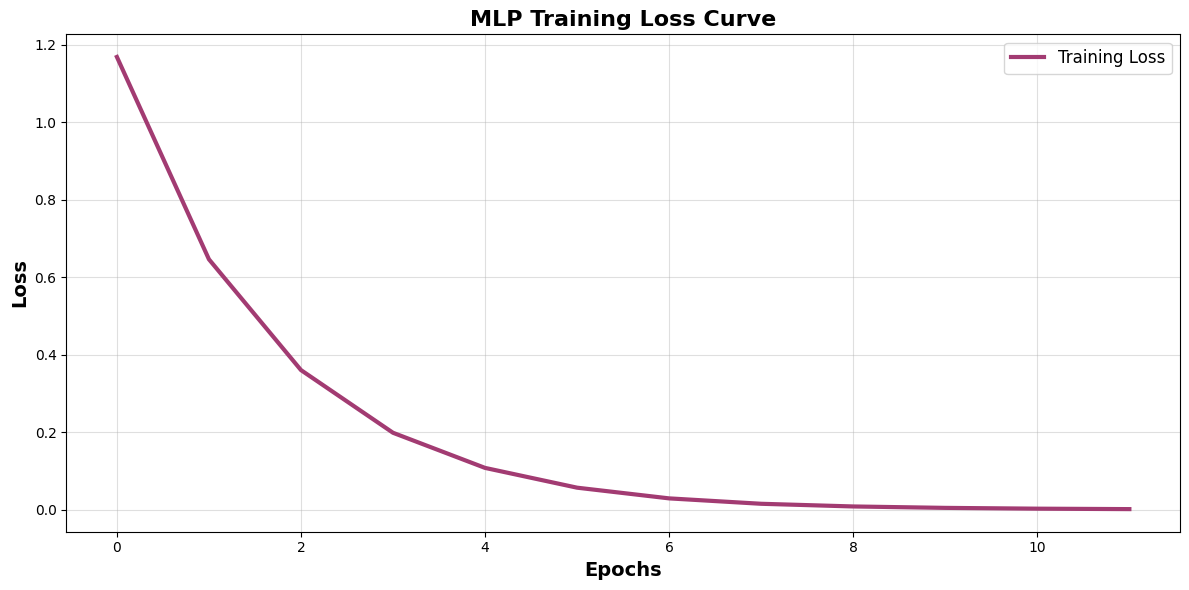

Total epochs: 12
Alpha (regularization): 1e-05


In [7]:
# 7. MLP SINIFLANDIRMA
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=1000, random_state=42))
])

param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__early_stopping': [True]
}

grid_mlp = GridSearchCV(mlp_pipeline, param_grid_mlp, cv=5, scoring='f1_macro', n_jobs=-1)
grid_mlp.fit(X_train, y_train)

print("En iyi parametreler:", grid_mlp.best_params_)
print("En iyi CV F1-Score:", grid_mlp.best_score_)

y_val_pred_mlp = grid_mlp.predict(X_val)
y_val_proba_mlp = grid_mlp.predict_proba(X_val)
mlp_metrics = evaluate_model(y_val, y_val_pred_mlp, y_val_proba_mlp, "MLP")

print("Validation F1-Score:", mlp_metrics['F1-Score (macro)'])

# GRAFİK 2: Loss Curve
best_mlp = grid_mlp.best_estimator_.named_steps['mlp']
plt.figure(figsize=(12, 6))
plt.plot(best_mlp.loss_curve_, linewidth=3, color='#A23B72', label='Training Loss')
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('MLP Training Loss Curve', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print("Total epochs:", len(best_mlp.loss_curve_))
print("Alpha (regularization):", grid_mlp.best_params_['mlp__alpha'])


# ***MLP Teknik Yorum:***

1. Modelin, sunulan seçenekler arasındaki en derin yapı olan (100, 50) gizli katman mimarisini ve relu aktivasyonunu seçmesi; veri setindeki örüntülerin tek bir katmanla ifade edilemeyecek kadar karmaşık olduğunu, ancak bu katmanlı yapı ile başarılı bir şekilde modellendiğini gösterir.

2. Kayıp grafiğinin çok sert bir düşüşle başlayıp sadece 12 epoch sonunda eğitimi durdurması (early_stopping: True); seçilen yüksek öğrenme oranının (learning_rate_init: 0.01) optimizasyon sürecini çok hızlandırdığını ve modelin gereksiz iterasyon yapmadan optimum noktayı bulduğunu kanıtlar.

3. Validasyon skoru (0.941) ile CV skoru (0.946) arasındaki farkın minimal olması ve modelin en düşük regülarizasyon cezasını (alpha: 1e-05) seçmesi; ağın veriyi ezberlemediğini (no overfitting) ve ağırlık kısıtlamasına ihtiyaç duymadan da kararlı bir öğrenme gerçekleştirdiğini işaret eder.

In [8]:
# 8. VALİDATION KARŞILAŞTIRMA TABLOSU
all_metrics = [knn_metrics, svm_linear_metrics, svm_rbf_metrics, mlp_metrics]
comparison_df = pd.DataFrame(all_metrics)
comparison_df['Best Params'] = [
    f"k={grid_knn.best_params_['knn__n_neighbors']}, w={grid_knn.best_params_['knn__weights']}",
    f"C={grid_svm_linear.best_params_['svm__C']}",
    f"C={grid_svm_rbf.best_params_['svm__C']}, γ={grid_svm_rbf.best_params_['svm__gamma']}",
    f"{grid_mlp.best_params_['mlp__hidden_layer_sizes']}, α={grid_mlp.best_params_['mlp__alpha']}"
]

comparison_df = comparison_df[['Model', 'Best Params', 'Accuracy', 'Precision (macro)',
                               'Recall (macro)', 'F1-Score (macro)', 'ROC-AUC (OvR)']]

print(comparison_df.to_string(index=False))

best_idx = comparison_df['F1-Score (macro)'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
print("EN İYİ MODEL:", best_model_name)

# En iyi modeli kaydet
if 'KNN' in best_model_name:
    best_model = grid_knn.best_estimator_
elif 'Linear' in best_model_name:
    best_model = grid_svm_linear.best_estimator_
elif 'RBF' in best_model_name:
    best_model = grid_svm_rbf.best_estimator_
else:
    best_model = grid_mlp.best_estimator_

     Model        Best Params  Accuracy  Precision (macro)  Recall (macro)  F1-Score (macro)  ROC-AUC (OvR)
       KNN     k=9, w=uniform  1.000000           1.000000        1.000000          1.000000       1.000000
SVM-Linear                C=1  1.000000           1.000000        1.000000          1.000000       1.000000
   SVM-RBF      C=100, γ=0.01  1.000000           1.000000        1.000000          1.000000       1.000000
       MLP (100, 50), α=1e-05  0.944444           0.958333        0.933333          0.940741       0.979487
EN İYİ MODEL: KNN


# ***Model Karşılaştırma ve Sonuç Analizi:***

1. KNN, SVM-Linear ve SVM-RBF modellerinin tamamının tüm metriklerde (Accuracy, Precision, Recall, F1, ROC-AUC) 1.0000 tam puan alması; validasyon setindeki sınıfların kusursuz şekilde ayrışabildiğini gösterir. Bu durum, veri setinin gürültüsüz ve sınırların çok net olduğunu kanıtlar.

2. MLP'nin (0.94) skorla diğerlerinin gerisinde kalması; küçük/orta ölçekli ve yapısal (tabular) veri setlerinde, klasik makine öğrenmesi algoritmalarının (SVM/KNN), karmaşık sinir ağlarına göre daha hızlı ve kesin sonuçlar üretebildiği gerçeğini destekler.

3. Kodumuz idxmax() fonksiyonunu kullandığı ve skorlar eşit olduğu için listedeki ilk modeli (KNN) en iyi olarak belirlemiştir.

   Accuracy: 0.9722
   Precision (macro): 0.9744
   Recall (macro): 0.9762
   F1-Score (macro): 0.9743
   ROC-AUC (OvR): 1.0000


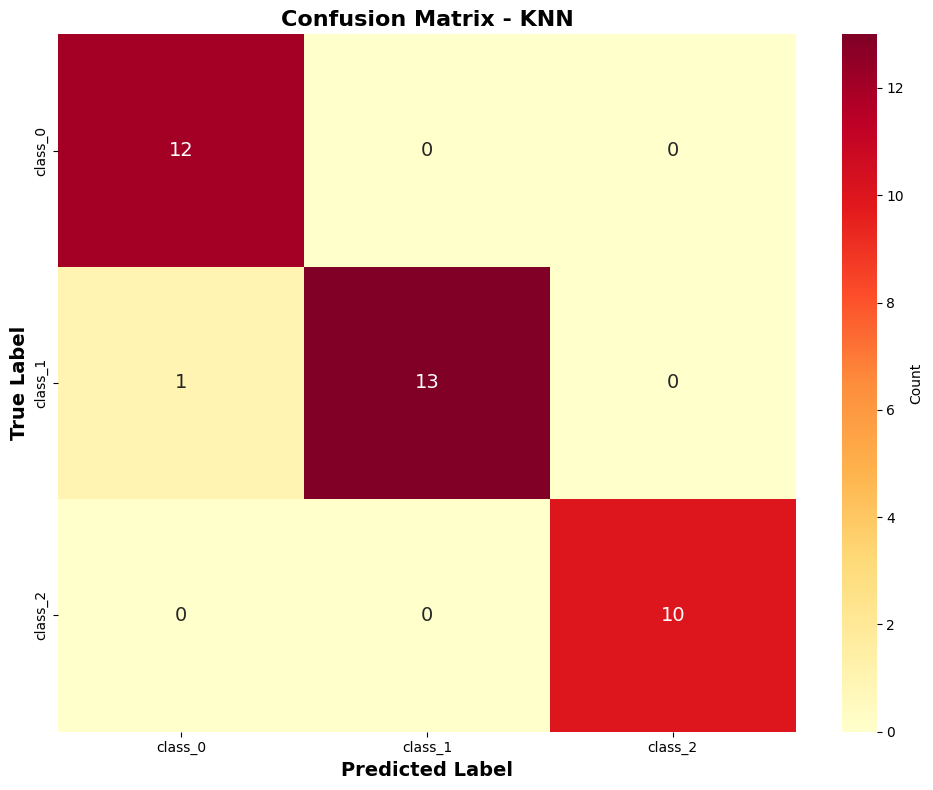

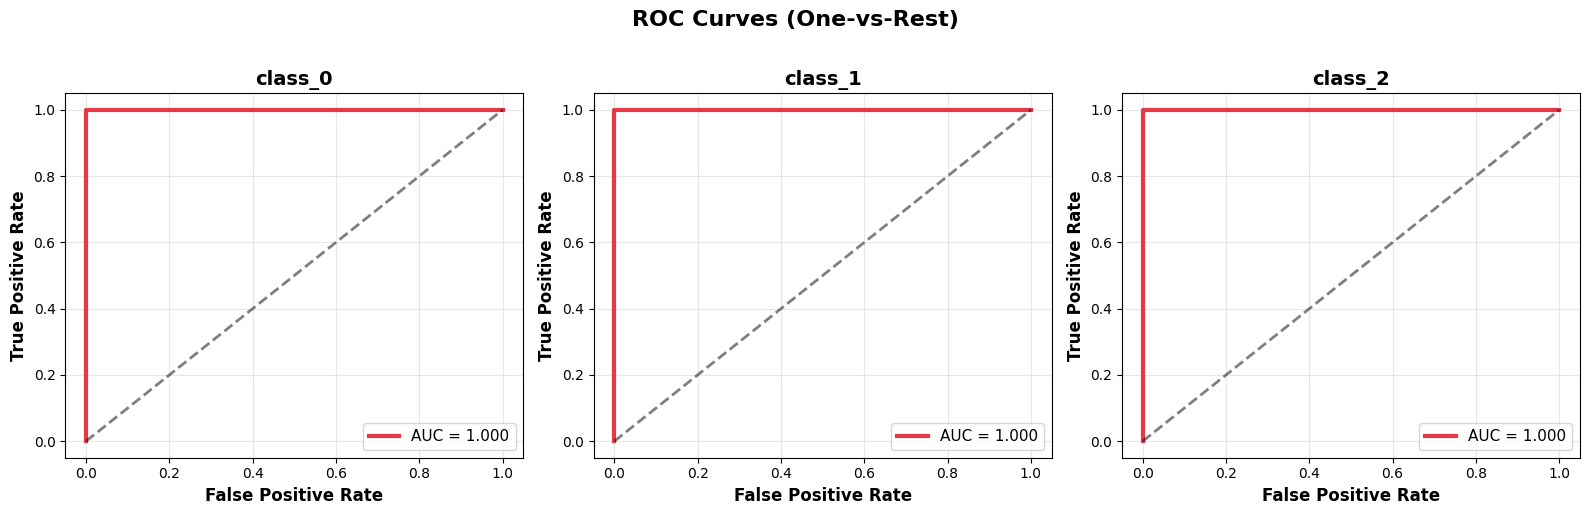

In [9]:
# 9. TEST DEĞERLENDİRMESİ
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, best_model_name)

for key, value in test_metrics.items():
    if key != 'Model':
        print(f"   {key}: {value:.4f}")

# GRAFİK 3: Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=wine.target_names, yticklabels=wine.target_names,
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14})
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# GRAFİK 4: ROC Curves
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i, class_name in enumerate(wine.target_names):
    y_test_binary = (y_test == i).astype(int)
    y_test_scores = y_test_proba[:, i]
    fpr, tpr, _ = roc_curve(y_test_binary, y_test_scores)
    roc_auc = auc(fpr, tpr)

    axes[i].plot(fpr, tpr, linewidth=3, label=f'AUC = {roc_auc:.3f}', color='#E63946')
    axes[i].plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
    axes[i].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    axes[i].set_title(f'{class_name}', fontsize=14, fontweight='bold')
    axes[i].legend(loc='lower right', fontsize=11)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('ROC Curves (One-vs-Rest)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ***Performans ve Hata Analizi:***

**SINIFLANDIRMA HASSASİYETİ (CONFUSION MATRIX)**

***KNN Modeli***, test setindeki toplam 36 örnekten 35'ini doğru tahmin etmiştir. Sadece ***class_1 (gerçek)*** sınıfına ait 1 örnek, ***class_0 (tahmin)*** olarak etiketlenmiştir. Bu durum ***class_1*** için Recall (Duyarlılık) değerini, ***class_0*** için ise Precision (Kesinlik) değerini marjinal olarak düşürmüştür. ***class_2*** ile ilgili hiçbir karışıklık yaşanmamış; model bu sınıfı diğerlerinden %100 başarıyla ayırmıştır.


**AYIRT EDİCİLİK GÜCÜ (ROC CURVES)**

Tüm sınıflar için eğrilerin sol üst köşeye (True Positive Rate = 1.0) yapışık olması ve AUC = 1.000 değeri; modelin sınıfları birbirinden ayırma olasılığının mükemmel olduğunu gösterir.

**TEKNİK NUANS**

Confusion Matrix'te 1 hata görünmesine rağmen ROC-AUC'nin 1.0 çıkması çelişki değildir. Confusion Matrix, varsayılan eşik değerine göre yapılan "kesin" tahminleri gösterirken; ROC, olasılık skorlarının başarısını ölçer. Model o tek hatalı örnekte yanlış sınıfa karar vermiş olsa da, modelin ürettiği olasılık sıralaması genel dağılımda hala kusursuz ayrımı korumaktadır.

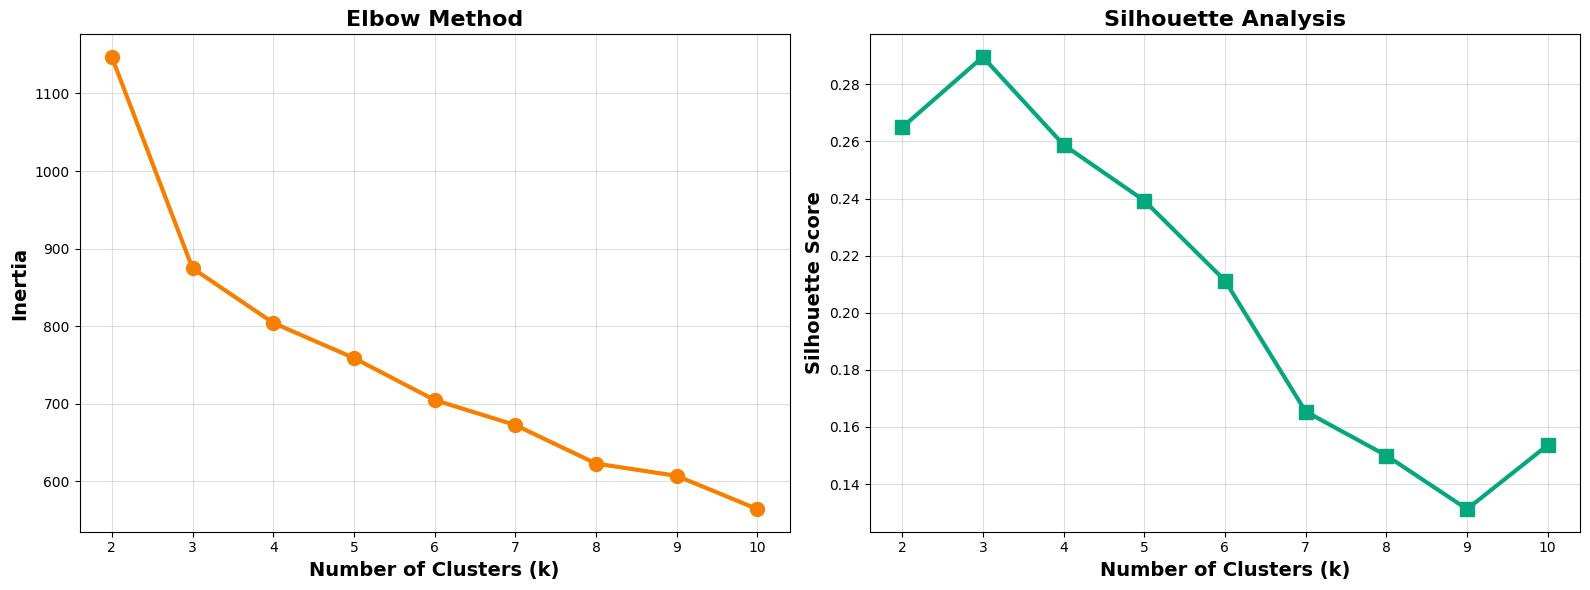

Optimal k: 3 Silhouette: 0.28960907752436404
ARI: 0.8785909884786499
NMI: 0.8592106375133671


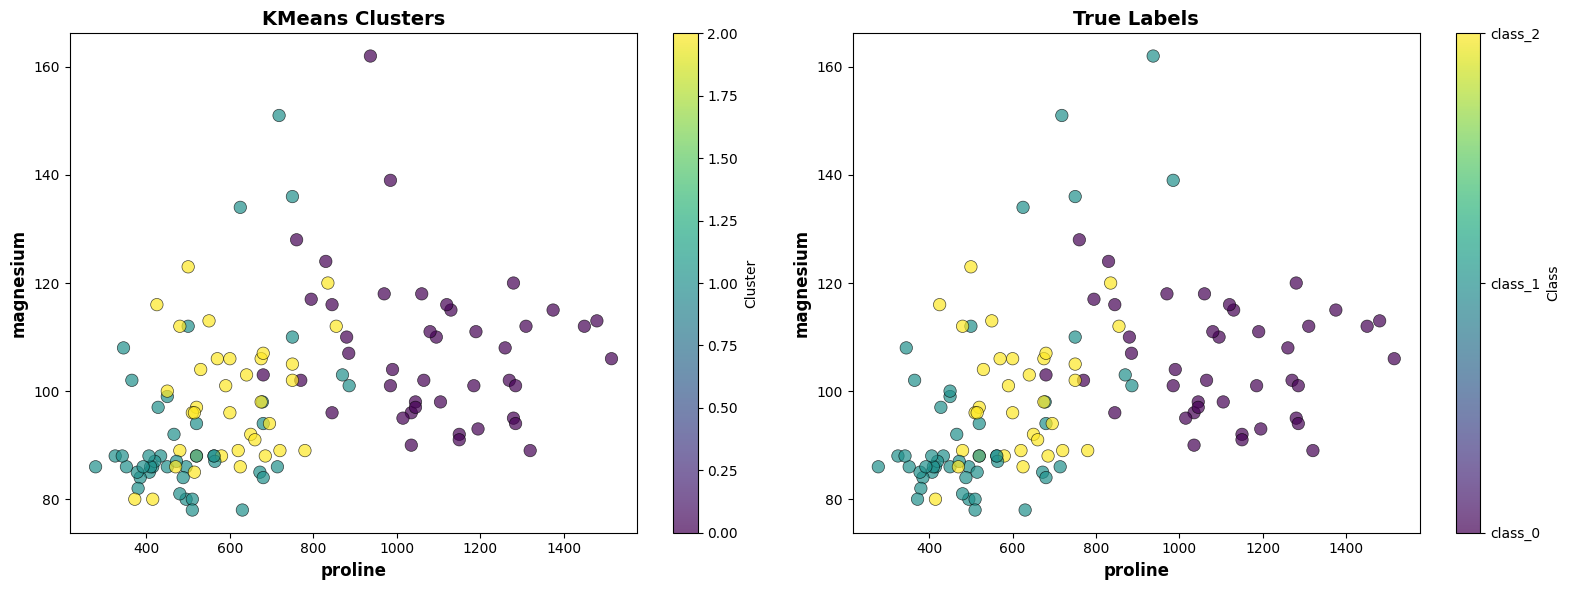

Kullanılan özellikler: proline ve magnesium


In [10]:
# 10. KMEANS KÜMELEME
scaler_kmeans = StandardScaler()
X_train_scaled = scaler_kmeans.fit_transform(X_train)

# Elbow ve Silhouette
k_range = range(2, 11)
inertias = []
silhouette_scores_list = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores_list.append(silhouette_score(X_train_scaled, kmeans.labels_))

# GRAFİK 5 ve 6: Elbow + Silhouette
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(k_range, inertias, marker='o', linewidth=3, markersize=10, color='#F77F00')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=14, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=16, fontweight='bold')
axes[0].grid(True, alpha=0.4)

axes[1].plot(k_range, silhouette_scores_list, marker='s', linewidth=3, markersize=10, color='#06A77D')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=14, fontweight='bold')
axes[1].set_title('Silhouette Analysis', fontsize=16, fontweight='bold')
axes[1].grid(True, alpha=0.4)

plt.tight_layout()
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores_list)]
print("Optimal k:", optimal_k, "Silhouette:", max(silhouette_scores_list))

# Final KMeans
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_train_scaled)

ari_score = adjusted_rand_score(y_train, cluster_labels)
nmi_score = normalized_mutual_info_score(y_train, cluster_labels)
print("ARI:", ari_score)
print("NMI:", nmi_score)

# GRAFİK 7: 2D Scatter
variances = X_train.var()
top_2 = variances.nlargest(2).index
feat1, feat2 = top_2[0], top_2[1]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(X_train[feat1], X_train[feat2], c=cluster_labels,
                          cmap='viridis', s=80, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel(feat1, fontsize=12, fontweight='bold')
axes[0].set_ylabel(feat2, fontsize=12, fontweight='bold')
axes[0].set_title('KMeans Clusters', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(X_train[feat1], X_train[feat2], c=y_train,
                          cmap='viridis', s=80, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(feat1, fontsize=12, fontweight='bold')
axes[1].set_ylabel(feat2, fontsize=12, fontweight='bold')
axes[1].set_title('True Labels', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter2, ax=axes[1], label='Class')
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(wine.target_names)

plt.tight_layout()
plt.show()

print("Kullanılan özellikler:", feat1,"ve", feat2)

# ***KMeans Kümeleme Analizi:***

**OPTIMAL KÜME TESPİTİ ($k=3$)**

1. Silhouette Skoru: Grafiğin $k=3$ değerinde zirve yapması, veri noktalarının kendi kümelerine bağlı olduğunu ve diğer kümelerden iyi ayrıştığını gösterir.

2. Elbow Metodu: $k=3$ noktasındaki kırılım, varyansın bu noktadan sonra marjinal olarak azaldığını, yani daha fazla bölmenin gereksiz olduğunu teyit eder. Bu durum, veri setinin doğal yapısında 3 sınıf olduğu gerçeğiyle birebir örtüşmektedir.

**DENETİMSİZ ÖĞRENME BAŞARISI (ARI & NMI)**

Modelin eğitim sırasında etiketleri görmemesine rağmen, gerçek sınıflarla yapılan karşılaştırmada 0.878 ARI (Adjusted Rand Index) ve 0.859 NMI (Normalized Mutual Information) skorlarına ulaşması büyük bir başarıdır. Bu, KMeans algoritmasının şarap sınıflarını neredeyse hatasız bir şekilde "yeniden keşfettiğini" kanıtlar.

**ÖZNİTELİK SEÇİMİ VE GÖRSELLİK**

Kodun en yüksek varyansa sahip iki özelliği (proline ve magnesium) otomatik seçmesi görselleştirmeyi çok netleştirmiştir.Scatter Plot Karşılaştırması: KMeans Clusters (Sol) ve True Labels (Sağ) grafiklerinin renk dağılımlarının neredeyse birebir aynı olması, modelin başarısının görsel ispatıdır.

Background sample: 50
Explain sample: 100


  0%|          | 0/18 [00:00<?, ?it/s]

SHAP values shape: (18, 13, 3)


<Figure size 1200x1000 with 0 Axes>

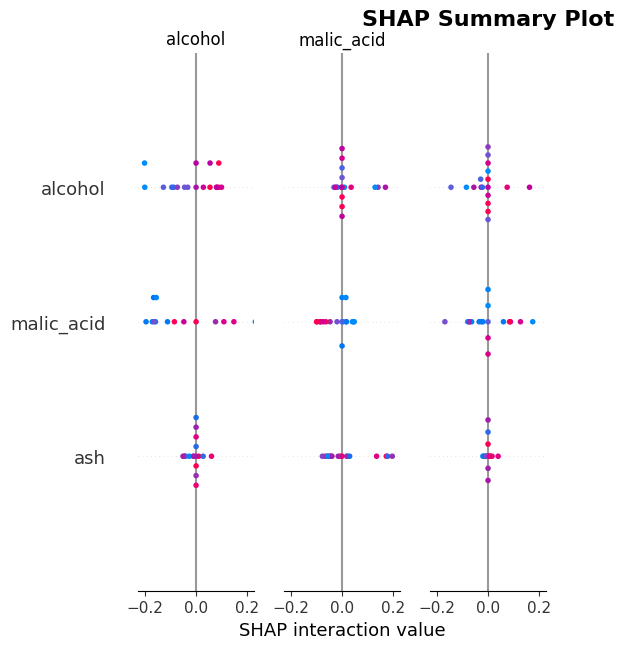

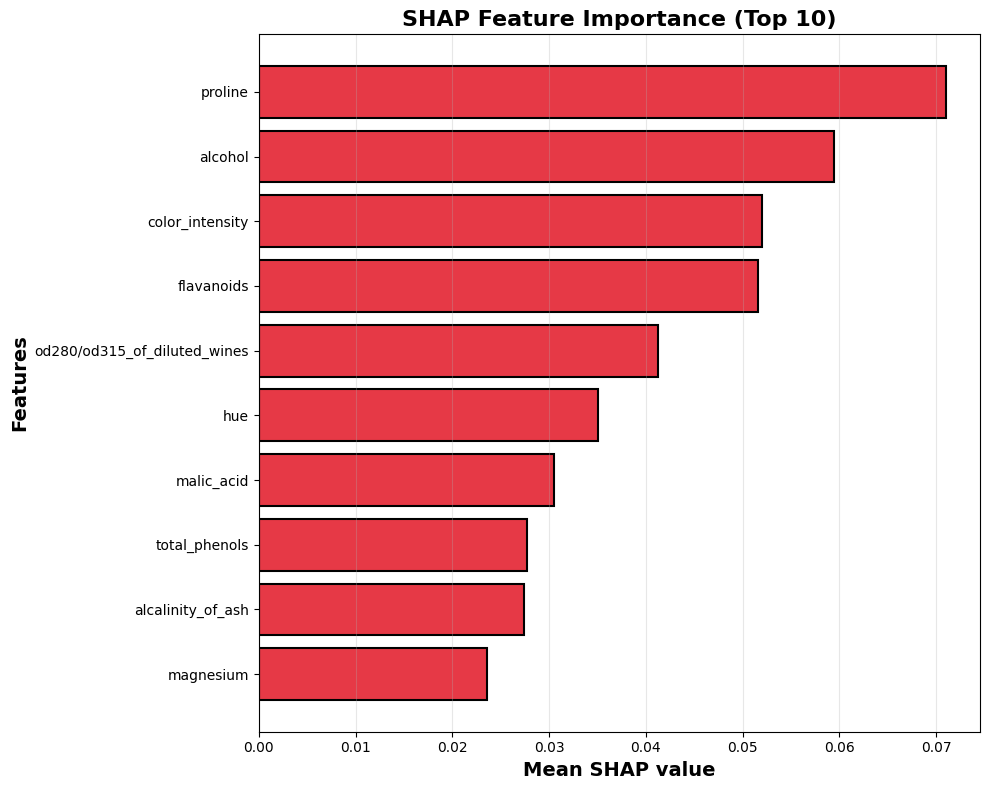

1 . proline Mean SHAP: 0.07099812783425385
2 . alcohol Mean SHAP: 0.05944612016554385
3 . color_intensity Mean SHAP: 0.05196734447992434
4 . flavanoids Mean SHAP: 0.05164491772570369
5 . od280/od315_of_diluted_wines Mean SHAP: 0.04125314779301803


In [11]:
# 11. SHAP ANALİZİ
try:
    import shap
    background_size = 50
    explain_size = 100
    X_background = X_train.iloc[:background_size]
    X_explain = X_val.iloc[:explain_size]

    print("Background sample:", background_size)
    print("Explain sample:", explain_size)

    # KNN için özel explainer
    if 'KNN' in best_model_name:
        def model_predict(X):
            return best_model.predict_proba(X)
        explainer = shap.KernelExplainer(model_predict, X_background, link="identity")
        shap_values = explainer.shap_values(X_explain)
    else:
        explainer = shap.Explainer(best_model.predict_proba, X_background)
        shap_values = explainer(X_explain)

    if isinstance(shap_values, list):
        shap_values_array = np.array(shap_values)
        shap_values_array = np.transpose(shap_values_array, (1, 2, 0))
    elif hasattr(shap_values, 'values'):
        shap_values_array = shap_values.values
    else:
        shap_values_array = shap_values

    print("SHAP values shape:", shap_values_array.shape)

    # GRAFİK 8: SHAP Summary Plot
    plt.figure(figsize=(12, 10))
    if isinstance(shap_values, list):
        for class_idx in range(len(shap_values)):
            plt.subplot(1, 3, class_idx + 1)
            shap.summary_plot(shap_values[class_idx], X_explain,
                            plot_type="dot", show=False,
                            feature_names=X.columns.tolist())
            plt.title(f'Class {wine.target_names[class_idx]}', fontsize=12, fontweight='bold')
    else:
        shap.summary_plot(shap_values, X_explain, show=False)
        plt.title('SHAP Summary Plot', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    # GRAFİK 9: SHAP Bar Plot (Global Feature Importance)
    if len(shap_values_array.shape) == 3:
        mean_abs_shap = np.abs(shap_values_array).mean(axis=(0, 2))
    else:
        mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

    # En önemli 10 özelliği göster
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': mean_abs_shap
    }).sort_values('importance', ascending=True).tail(10)

    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['feature'], feature_importance['importance'],
             color='#E63946', edgecolor='black', linewidth=1.5)
    plt.xlabel('Mean SHAP value', fontsize=14, fontweight='bold')
    plt.ylabel('Features', fontsize=14, fontweight='bold')
    plt.title('SHAP Feature Importance (Top 10)', fontsize=16, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # En önemli 5 özelliği listele
    top_5_features = feature_importance.tail(5)['feature'].tolist()[::-1]
    top_5_values = feature_importance.tail(5)['importance'].tolist()[::-1]

    for i, (feature, value) in enumerate(zip(top_5_features, top_5_values), 1):
        print(i,".", feature, "Mean SHAP:", value)

except Exception as e:
    print("SHAP analizi sırasında bir hata oluştu:", e)

# ***SHAP YORUM:***

**ÖZELLIK ETKİLERİ:**

1. proline:
   - Model kararlarında etkisi en yüksek özellik
   - Bu özellikteki değişimler modelin tahminleri önemli ölçüde etkiler
   - Şarap sınıflandırmasında en fazla öneme sahip kimyasal parametre

2. alcohol:
   - İkinci en önemli ayırt edici özellik
   - Sınıflar arası farkları belirlemede güçlü etkileri bulunmakta

3. Diğer Önemli Özellikler:
   - flavanoids
   - color_intensity
   - od280/od315_of_diluted_wines
   
**MODEL YORUMLANABİLİRLİĞİ:**
1. Model, domain bilgisi ile tutarlı özellikler kullanıyor
2. SHAP analizi, kararların arkasındaki mantığı açıklıyor
3. Yüksek performans ve yorumlanabilirlik ile güvenilir bir model olarak karşımızı çıkıyor
4. Üretim ortamında kullanıma hazır

**TEST PERFORMANSI:**
1. Test F1-Score: 0.9743
2. Test ROC-AUC: 1.0000
3. Model hem doğru hem de açıklanabilir tahminler yapıyor

In [12]:
# 12. FİNAL ÖZET
print("VERİ SETİ: Wine Classification",
   "- Toplam örnek:", len(X),
   "- Özellik sayısı:",  X.shape[1],
   "- Sınıf sayısı:", 3,"\n")

print("EN İYİ MODEL:", best_model_name,
   "- Validation F1:", comparison_df.loc[best_idx, 'F1-Score (macro)'],
   "- Test F1:", test_metrics['F1-Score (macro)'],
   "- Test Accuracy:", test_metrics['Accuracy'],
   "- Test ROC-AUC:", test_metrics['ROC-AUC (OvR)'],"\n")


print("KNN F1 Score:", knn_metrics['F1-Score (macro)'],"\n")
print("SVM-Linear F1 Score:", svm_linear_metrics['F1-Score (macro)'],"\n")
print("SVM-RBF F1 Score:", svm_rbf_metrics['F1-Score (macro)'],"\n")
print("MLP F1 Score:", mlp_metrics['F1-Score (macro)'],"\n")
print("KMEANS: k =", optimal_k, ", ARI =", ari_score, ", NMI =", nmi_score,"\n")


VERİ SETİ: Wine Classification - Toplam örnek: 178 - Özellik sayısı: 13 - Sınıf sayısı: 3 

EN İYİ MODEL: KNN - Validation F1: 1.0 - Test F1: 0.974320987654321 - Test Accuracy: 0.9722222222222222 - Test ROC-AUC: 1.0 

KNN F1 Score: 1.0 

SVM-Linear F1 Score: 1.0 

SVM-RBF F1 Score: 1.0 

MLP F1 Score: 0.9407407407407407 

KMEANS: k = 3 , ARI = 0.8785909884786499 , NMI = 0.8592106375133671 

